# Implementation of the Tank in Series Model using PYBAMM

In this notebook, we show how to solve the Tank in Series Model using solvers built into PyBAMM. For the purposes of this example, we use the CasADi solver that comes pre-installed with PyBAMM, but the syntax remains the same for other solvers

In [5]:
# Setup
import pybamm
import tests
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from pprint import pprint
os.chdir(pybamm.__path__[0]+'/..')

# Create solver
dae_solver = pybamm.CasadiSolver(mode="safe") # use safe mode so that solver stops at events

## Integrating DAEs

Setting up constants and the discharge rate. 

In [6]:
# Constants
F = 96487;  # Faraday's Constant
R = 8.314472;  # Universal Gas Constant
T = 273.15 + 25;  # Surface Temperature of the Cell

alphaca = 0.5;
alphacc = 0.5;
alphaaa = 0.5;
alphaac = 0.5;

# Discharge rate
ratetest = -1;
t_eval = np.linspace(0, int(3600/abs(ratetest)), int(3600/abs(ratetest)));

Add supporting functions. Use PyBAMM Built in math functions.

In [7]:
def Ionic_Conductivity(p,T,c):
    return 0.1*0.001*p[8]*c*((-10.5+0.0740*T-0.0000696*T**2)+0.001*p[8]*c*(0.668-0.0178*T+0.000028*T**2)+0.000001*(p[8]*c)**2*(0.494-8.86e-4*T))**2;


def OCV_pos(socp):
    return -10.72*socp**4+23.88*socp**3-16.77*socp**2+2.595*socp+4.563;


def OCV_neg(socn):
    return .1493+.8493*pybamm.exp(-61.79*socn)+.3824*pybamm.exp(-665.8*socn)-pybamm.exp(39.42*socn-41.92)-.3131e-1*pybamm.arctan(25.59*socn-4.099)-.9434e-2*pybamm.arctan(32.49*socn-15.74);


def LiTank_Parameters():

    # DOI :  https://doi.org/10.1115/1.4028154
    # Article Reference : A Temperature Dependent, Single Particle, Lithium Ion Cell Model Including Electrolyte Diffusion
    # T. R. Tanim, C. D. Rahn, and C. Y. Wang, J. Dyn. Syst. Meas. Control. Trans. ASME, 137, 011005 (2015)

    p = np.tile(np.float32(0), 26);

    # Model parameters
    p[1] = 1.4E-14;   # Solid phase diffusion coefficient in negative electrode (m**2/s)        (Dsn)
    p[2] = 2E-14;     # Solid phase diffusion coefficient in positive electrode (m**2/s)        (Dsp)
    p[3] = 5E-6; 			  # Radius of the particle in negative electrode (m)                       (Rpn)
    p[4] = 5E-6; 			  # Radius of the particle in positive electrode (m)                       (Rpp)
    p[5] = 1.5; 			  # bruggemann coefficient negative electrode                              (brugn)
    p[6] = 1.5; 			  # bruggemann coefficient positive electrode                              (brugp)
    p[7] = 1.5; 			  # bruggemann coefficient separator                                       (brugs)
    p[8] = 1200; 			  # Initial electrolyte concentration           (mol/m**3)                  (c0)
    p[9] = 31080;             # Maximum particle phase concentration in negative electrode(mol/m**3)   (ctn)
    p[10] = 51830;            # Maximum particle phase concentration in positive electrode(mol/m**3)    (ctp)
    p[11] = 0.038;   		  # Filler fraction in negative electrode                                  (efn)
    p[12] = 0.12;   		  # Filler fraction in positive electrode                                  (efp)
    p[13] = 0.30; 			  # Porosity in negative electrode                                         (en)
    p[14] = 0.30; 			  # Porosity in positive electrode                                         (ep)
    p[15] = 0.40; 			  # porosity in separator                                                  (es)
    p[16] = 6.626E-10;	      # Reaction rate constant in negative electrode (m**2.5/mol**0.5 s)         (kn)
    p[17] = 2.405E-10; 		  # Reaction rate constant in positive electrode (m**2.5/mol**0.5 s)         (kp)
    p[18] = 40e-6;   		  # Thickness of negative electrode              (m)                       (ln)
    p[19] = 36.55e-6;   	  # Thickness of positive electrode              (m)                       (lp)
    p[20] = 25e-6;    		  # Thickness of separator                       (m)                       (ls)
    p[21] = 0.79079;          # Initial particle phase concentration (scaled) negative electrode       (socn)
    p[22] = 0.35973;          # Initial particle phase concentration (scaled) positive electrode       (socp)
    p[23] = 0.38; 			  # transference number                                                    (t+)
    p[24] = 17.54;            # Current density at 1C-rate (A/m**2)                                     (capacity)
    p[25] = 0.28241E-9;       # Electrolyte Diffusivity (m**2/s)                                        (Dl)

    return p;


Introduce boundary conditions. Some solvers need an initial estimate for the derivatives that are all set to 0.

In [8]:
def initial_conditions(p):

    x0 = np.tile(np.float32(0), 14)
    xp0 = np.tile(np.float32(0), 14)

    socp = p[22];
    socn = p[21];

    Up0 = -10.72 * socp ** 4 + 23.88 * socp ** 3 - 16.77 * socp ** 2 + 2.595 * socp + 4.563;
    Un0 = .1493 + .8493 * math.exp(-61.79 * socn) + .3824 * math.exp(-665.8 * socn) - math.exp(
        39.42 * socn - 41.92) - 0.03131 * math.atan(25.59 * socn - 4.099) - 0.009434 * math.atan(32.49 * socn - 15.74);

    x0[0] = 1.00000000000000;
    x0[1] = 1.00000000000000;
    x0[2] = 1.00000000000000;
    x0[3] = socp;
    x0[4] = socn;
    x0[5] = 0;
    x0[6] = .997602877697382;
    x0[7] = 1.00020002000133;
    x0[8] = 1.00230264702900;
    x0[9] = Up0;
    x0[10] = Un0;
    x0[11] = socp;
    x0[12] = socn;
    x0[13] = Up0 - Un0;

    return x0, xp0



def c12(p,c1,c2,c3):
    c12 = (p[14] ** p[6] / p[19] * c1 + p[15] ** p[7] / p[20] * c2) / (p[14] ** p[6] / p[19] + p[15] ** p[7] / p[20]);
    return c12;


def c23(p,c1,c2,c3):
    c23 = (p[13] ** p[5] / p[18] * c3 + p[15] ** p[7] / p[20] * c2) / (p[13] ** p[5] / p[18] + p[15] ** p[7] / p[20]);
    return c23;


def kappa_c12(p,T,c1,c2,c3):
    kappa_c12 = Ionic_Conductivity(p, T, (p[14] ** p[6] / p[19] * c1 + p[15] ** p[7] / p[20] * c2) / (p[14] ** p[6] / p[19] + p[15] ** p[7] / p[20]));
    return kappa_c12;


def kappa_c23(p,T,c1,c2,c3):
    kappa_c23 = Ionic_Conductivity(p, T,  (p[13] ** p[5] / p[18] * c3 + p[15] ** p[7] / p[20] * c2) / (p[13] ** p[5] / p[18] + p[15] ** p[7] / p[20]));
    return kappa_c23;


def S12(p,T,c1,c2,c3):
    S12 = 2 * kappa_c12(p,T,c1,c2,c3) / (p[19] / (p[14] ** p[6]) + p[20] / (p[15] ** p[7]));
    return S12;


def S23(p,T,c1,c2,c3):
    S23 = 2 * kappa_c23(p,T,c1,c2,c3) / (p[18] / (p[13] ** p[5]) + p[20] / (p[15] ** p[7]));
    return S23;


def Up(csurfs1):
    Up = OCV_pos(csurfs1);
    return Up;


def Un(csurfs3):
    Un = OCV_neg(csurfs3);
    return Un;


def eta_p(phis1, phi11):
    eta_p = phis1 - pybamm.log(phi11) - Up(csurfs1);
    return eta_p;


def eta_n(phis3, phi13):
    eta_n = phis3 - pybamm.log(phi13) - Un(csurfs3);
    return eta_n;


Preparing the coefficients of the Tank in Series Model

In [9]:
p = LiTank_Parameters()

x0, xp0 = initial_conditions(p)

# Electrolyte Diffusivities at Interfacial Concentration
Dl_c12 = p[25];
Dl_c23 = p[25];

# parameters
ap = 3 / p[4] * (1 - p[12] - p[14]);
an = 3 / p[3] * (1 - p[11] - p[13]);

# Electrolyte Volume expressions in Tank Model (per unit area)
V_l1 = p[14] * p[19];
V_l2 = p[15] * p[20];
V_l3 = p[13] * p[18];

iapp = p[24] * ratetest;

# Mass Tansport expressions in Tank Model (m/s)
K12 = 2 * Dl_c12 / (p[19] / (p[14] ** p[6]) + p[20] / (p[15] ** p[7]));
K23 = 2 * Dl_c23 / (p[18] / (p[13] ** p[5]) + p[20] / (p[15] ** p[7])); 

Setting up the model in PyBAMM. PyBAMM likes to use individual variables in the model. Note the event at the end that limits V to >= 2.8.

In [10]:
# Create model
model = pybamm.BaseModel()

c1 = pybamm.Variable("c1")
c2 = pybamm.Variable("c2")
c3 = pybamm.Variable("c3")
c1savg = pybamm.Variable("c1savg")
c3savg = pybamm.Variable("c3savg")
ah = pybamm.Variable("ah")
phi11 = pybamm.Variable("phi11")
phi12 = pybamm.Variable("phi12")
phi13 = pybamm.Variable("phi13")
phis1 = pybamm.Variable("phis1")
phis3 = pybamm.Variable("phis3")
csurfs1 = pybamm.Variable("csurfs1")
csurfs3 = pybamm.Variable("csurfs3")
v = pybamm.Variable("v")

model.variables = {"c1": c1,
                   "c2": c2,
                   "c3": c3,
                   "c1savg": c1savg,
                   "c3savg": c3savg,
                   "ah": ah,
                   "phi11": phi11,
                   "phi12": phi12,
                   "phi13": phi13,
                   "phis1": phis1,
                   "phis3": phis3,
                   "csurfs1": csurfs1,
                   "csurfs3": csurfs3,
                   "v": v};

# Define the equations
model.rhs  = {c1:  (K12 / V_l1 * (c2 - c1) + ap * (1 - p[23]) * p[17] * (p[8] * c1) ** alphacc * p[10] * (
        1 - csurfs1) ** alphaca * csurfs1 ** alphacc * (
                               pybamm.exp(alphaca * F / R / T * eta_p(phis1, phi11)) - pybamm.exp(-alphacc * F / R / T * eta_p(phis1, phi11))) / p[14] /
                       p[8]),
                          c2:  ((-K12 * (c2 - c1) + K23 * (c3 - c2)) / V_l2),
                          c3:  (-K23 / V_l3 * (c3 - c2) + an * (1 - p[23]) * p[16] * (p[8] * c3) ** alphaaa * p[9] * (
        1 - csurfs3) ** alphaaa * csurfs3 ** alphaac * (
                               pybamm.exp(alphaaa * F / R / T * eta_n(phis3, phi13)) - pybamm.exp(-alphaac * F / R / T * eta_n(phis3, phi13))) / p[13] /
                       p[8]),
                          c1savg: (-3 * iapp / ap / p[19] / F / p[10] / p[4]),
                          c3savg: (3 * iapp / an / p[18] / F / p[9] / p[3]),
                          ah:  (1 / 3600 * abs(iapp))};

model.algebraic = {phi11: -S12(p,T,c1,c2,c3) * (pybamm.log(phi12) - pybamm.log(phi11)) + 2 * R * T * (1 - p[23]) / F * S12(p,T,c1,c2,c3) * (c2 - c1) / c12(p,c1,c2,c3) - iapp,
                                phi12: (p[14] ** p[6] / p[19] * pybamm.log(phi11) + p[15] ** p[7] / p[20] * pybamm.log(phi12)) / (
        p[14] ** p[6] / p[19] + p[15] ** p[7] / p[20]),
                                phi13: -S23(p,T,c1,c2,c3) * (pybamm.log(phi13) - pybamm.log(phi12)) + 2 * R * T * (1 - p[23]) / F * S23(p,T,c1,c2,c3) * (c3 - c2) / c23(p,c1,c2,c3) - iapp,
                                phis1: p[17] * (p[8] * c1) ** alphacc * p[10] * (1 - csurfs1) ** alphaca * csurfs1 ** alphacc * (
        pybamm.exp(alphaca * F / R / T * eta_p(phis1, phi11)) - pybamm.exp(-alphacc * F / R / T * eta_p(phis1, phi11))) - iapp / ap / p[19] / F,
                                phis3: p[16] * (p[8] * c3) ** alphaaa * p[9] * (1 - csurfs3) ** alphaaa * csurfs3 ** alphaac * (
        pybamm.exp(alphaaa * F / R / T * eta_n(phis3, phi13)) - pybamm.exp(-alphaac * F / R / T * eta_n(phis3, phi13))) + iapp / an / p[18] / F,
                                csurfs1: p[2] * p[10] * (csurfs1 - c1savg) / p[4] + 1 / 5 * iapp / ap / p[19] / F,
                                csurfs3: p[1] * p[9] * (csurfs3 - c3savg) / p[3] - 1 / 5 * iapp / an / p[18] / F,
                                v: v - phis1 + phis3};

model.initial_conditions = {c1: x0[0],
                            c2: x0[1],
                            c3: x0[2],
                            c1savg: x0[3],
                            c3savg: x0[4],
                            ah: x0[5],
                            phi11: x0[6],
                            phi12: x0[7],
                            phi13: x0[8],
                            phis1: x0[9],
                            phis3: x0[10],
                            csurfs1: x0[11],
                            csurfs3: x0[12],
                            v: x0[13]};

model.events.append(pybamm.Event('v=2.8', v - 2.8))

Discretize and run the model

In [11]:

# Discretise using default discretisation
disc = pybamm.Discretisation();
disc.process_model(model);

# Solve #################################
solution = dae_solver.solve(model, t_eval);
#########################################

Now the model can be solved by calling `solver.solve` with a specific time vector at which to evaluate the solution

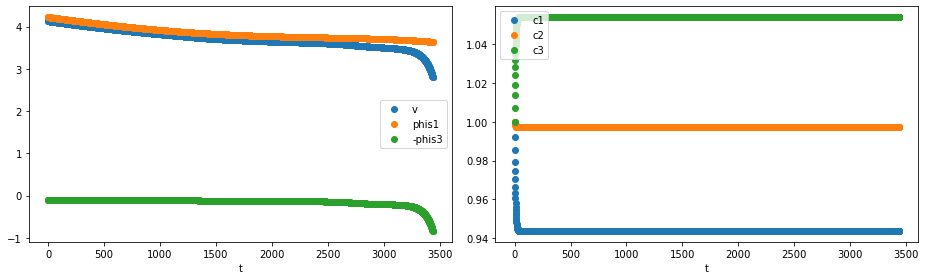

In [12]:
# Extract and plot quantities
t_sol = solution.t
v = solution["v"]
c1 = solution["c1"]
c2 = solution["c2"]
c3 = solution["c3"]

phis1 = solution["phis1"]
phis3 = solution["phis3"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
ax1.plot(t_sol, v(t_sol), "o")
ax1.plot(t_sol, phis1(t_sol), "o")
ax1.plot(t_sol, -phis3(t_sol), "o")
ax1.set_xlabel("t")
ax1.legend(["v", "phis1", "-phis3"], loc="best")

ax2.plot(t_sol, c1(t_sol), "o")
ax2.plot(t_sol, c2(t_sol), "o")
ax2.plot(t_sol, c3(t_sol), "o")
ax2.set_xlabel("t")
ax2.legend(["c1","c2","c3"], loc="best")

plt.tight_layout()
plt.show()